In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GATA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn000061,MGPVDGKSSFYSPKHSSDDINYLLEFSYDDYRCMDLLSIFPESETT...,270,1
1,Achn029831,MYGHTQSMNASDRFAAAEDDSSAGGDDSVGIDGVEVVPPDAVYGDG...,213,1
2,Achn041731,MAAANPRPLQARPYEDYVQLPAIQIEDDEDGEYEDGGDDDMEEADG...,309,1
3,Achn050821,METPELLAGGYFSPGSRYFEKKSTENVNNHFAIDDLLDFSKEDDVM...,314,1
4,Achn075641,MDYVEAALKPSFEPPKKAQSQPQAFSVDSPAVNGVSGDDFFVDDLL...,303,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
9260,0.011561,0.000000,0.000000,0.011561,0.00000,0.014451,0.000000,0.000000,0.002890,0.000000,...,0.005780,0.008671,0.005780,0.000000,0.002890,0.000000,0.000000,0.0,0.0,0.002890
1694,0.006024,0.002410,0.002410,0.001205,0.00000,0.006024,0.001205,0.004819,0.003614,0.007229,...,0.000000,0.002410,0.001205,0.003614,0.002410,0.000000,0.001205,0.0,0.0,0.001205
9998,0.002421,0.000000,0.002421,0.002421,0.00000,0.000000,0.000000,0.000000,0.002421,0.004843,...,0.002421,0.002421,0.002421,0.000000,0.000000,0.000000,0.002421,0.0,0.0,0.000000
783,0.018277,0.002611,0.000000,0.002611,0.00000,0.000000,0.000000,0.000000,0.005222,0.002611,...,0.000000,0.002611,0.002611,0.000000,0.002611,0.002611,0.000000,0.0,0.0,0.000000
3377,0.029520,0.003690,0.011070,0.000000,0.00738,0.003690,0.000000,0.000000,0.003690,0.003690,...,0.000000,0.000000,0.000000,0.007380,0.003690,0.000000,0.003690,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 441)
X_test: (2128, 441)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:08 642ms/step - accuracy: 0.6094 - loss: 0.6930

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5726 - loss: 0.6905    

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6574 - loss: 0.6711

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7162 - loss: 0.6167

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7519 - loss: 0.5651

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7530 - loss: 0.5633 - val_accuracy: 0.9759 - val_loss: 0.0751


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0606

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9612 - loss: 0.0984 

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.0910

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.0869

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.0847

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9700 - loss: 0.0844 - val_accuracy: 0.9777 - val_loss: 0.0570


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0239

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0566 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0545

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0537

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0540

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0541 - val_accuracy: 0.9818 - val_loss: 0.0527


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0092

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9786 - loss: 0.0665 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0596

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0552

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0524

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0521 - val_accuracy: 0.9665 - val_loss: 0.0986


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0181

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0336 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0388

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0415

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0425

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0426 - val_accuracy: 0.9794 - val_loss: 0.0566


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0081

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0370 

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0375

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0374

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0395

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0397 - val_accuracy: 0.9724 - val_loss: 0.0845


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0134

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0301 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0331

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0347

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0345

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0344 - val_accuracy: 0.9794 - val_loss: 0.0681


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0034

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0343 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0380

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0390

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0384

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0383 - val_accuracy: 0.9706 - val_loss: 0.0974


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0472

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0351 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0368

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0367

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0360

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0358 - val_accuracy: 0.9794 - val_loss: 0.0677


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0090

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0333 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0315

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0301

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0305

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0305 - val_accuracy: 0.9794 - val_loss: 0.0704


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0295

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0232 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0287

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0306

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0309

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0308 - val_accuracy: 0.9818 - val_loss: 0.0704


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0680

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0239 

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0243

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0242

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0237

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0236 - val_accuracy: 0.9830 - val_loss: 0.0689


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0180

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0274 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0266

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0248

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0237

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0236 - val_accuracy: 0.9824 - val_loss: 0.0646


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 8.2909e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0092     

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0121

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0152

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0181

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.9818 - val_loss: 0.0666


Epoch 15/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0027

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0079 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0111

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0132

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0143

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0145 - val_accuracy: 0.9806 - val_loss: 0.0638


Epoch 16/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0023

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0169 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0175

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0176

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0173

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.9830 - val_loss: 0.0646


Epoch 17/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.2219e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0102     

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0129

 73/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0146

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0148

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.9800 - val_loss: 0.0865


Epoch 18/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0012

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0048 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0088

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0113

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0128

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.9794 - val_loss: 0.0827


Epoch 19/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0016

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0224 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0202

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0197

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0192

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0190 - val_accuracy: 0.9800 - val_loss: 0.0757


Epoch 20/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0016

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0056 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0083

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0092

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0094

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.9841 - val_loss: 0.0741


Epoch 21/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0016

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0088 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0078

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0080

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0088

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0093 - val_accuracy: 0.9119 - val_loss: 0.3602


Epoch 22/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.2147

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0675 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0499

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0413

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0360

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0345 - val_accuracy: 0.9771 - val_loss: 0.0880


Epoch 23/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0052

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0080 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0111

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0111

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0108

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0108 - val_accuracy: 0.9806 - val_loss: 0.0859


Epoch 24/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 9.8852e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0111     

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0149

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0155

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0162

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0163 - val_accuracy: 0.9836 - val_loss: 0.0711


Epoch 25/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0028

 24/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0237 

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0245

 73/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0240

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0234

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0231 - val_accuracy: 0.9836 - val_loss: 0.0633


Epoch 26/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0017

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0066 

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0077

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0080

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0081

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0081 - val_accuracy: 0.9794 - val_loss: 0.0951


Epoch 27/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.3373e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0072     

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0075

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0074

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0071

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0070 - val_accuracy: 0.9818 - val_loss: 0.0867


Epoch 28/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 8.0067e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0132     

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0134

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0124

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0116

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0114 - val_accuracy: 0.9794 - val_loss: 0.0902


Epoch 29/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0272

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0051 

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0045

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0044

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0045

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9812 - val_loss: 0.0846


Epoch 30/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.4809e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0021     

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0021

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0027

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0032

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9800 - val_loss: 0.0934



[Train Accuracy: 99.85% - Test Accuracy: 98.59%]


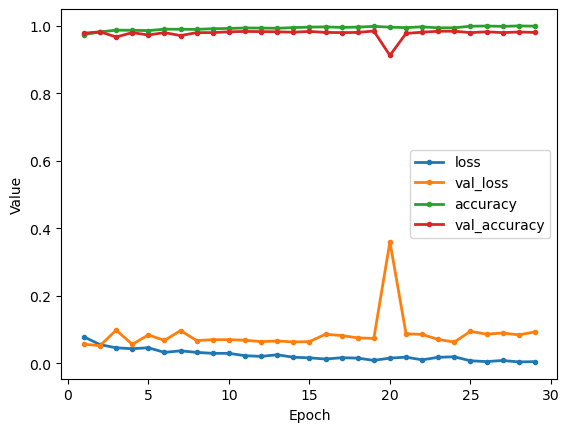

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
9260,0.000000,0.0,0.000000,0.002899,0.000000,0.002899,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.002899,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.001206,0.0,0.000000,0.000000,0.000000,0.001206,0.0,0.001206,0.0,0.001206,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
783,0.005236,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3377,0.011111,0.0,0.003704,0.000000,0.003704,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 8888)
X_test: (2128, 8888)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,275,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,318,849 (8.85 MB)

 Trainable params: 2,318,849 (8.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:10 662ms/step - accuracy: 0.4219 - loss: 0.6931

  6/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4332 - loss: 0.6934   

 11/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4532 - loss: 0.6933

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4665 - loss: 0.6931

 24/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4749 - loss: 0.6925 

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4847 - loss: 0.6915

 38/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4977 - loss: 0.6896

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5131 - loss: 0.6861

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5323 - loss: 0.6794

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5495 - loss: 0.6711

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5662 - loss: 0.6607

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5821 - loss: 0.6486

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5972 - loss: 0.6352

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6114 - loss: 0.6212

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6247 - loss: 0.6069

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6370 - loss: 0.5928

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6469 - loss: 0.5811 - val_accuracy: 0.9730 - val_loss: 0.0863


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9844 - loss: 0.0208

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9911 - loss: 0.0191 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0238

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9913 - loss: 0.0247

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9916 - loss: 0.0250

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9918 - loss: 0.0248

 43/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0243

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9923 - loss: 0.0238

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9924 - loss: 0.0235

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9924 - loss: 0.0234

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9925 - loss: 0.0232

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9926 - loss: 0.0231

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9926 - loss: 0.0229

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9927 - loss: 0.0227

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0226

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0225

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9929 - loss: 0.0223 - val_accuracy: 0.9953 - val_loss: 0.0184


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 0.0017

  7/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9989 - loss: 0.0062 

 13/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9987 - loss: 0.0067

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0065

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0062

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0060

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0057

 47/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0057

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0058

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0058

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0058

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0057

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0057

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0056

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0056

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0055

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9993 - loss: 0.0054 - val_accuracy: 0.9947 - val_loss: 0.0177


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.5915e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010     

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 47/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0012

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0013

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0014

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0015

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0016

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0016

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0017

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0017

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0018

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9971 - val_loss: 0.0135


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0040

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7857e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4872e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2261e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9919e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8266e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6743e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5107e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.3974e-04 - val_accuracy: 0.9959 - val_loss: 0.0144


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.0167e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7552e-04 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8840e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8935e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0740e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4005e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5431e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7171e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8565e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9667e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0464e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1005e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1436e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2220e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3288e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5418e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.7222e-04 - val_accuracy: 0.9853 - val_loss: 0.0552


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0035

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7030e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4840e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6405e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0247e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4830e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1576e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8364e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5689e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3423e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1459e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9975e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9154e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8710e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.8401e-04 - val_accuracy: 0.9959 - val_loss: 0.0148


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.2069e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8199e-05 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7848e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4139e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7569e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.0403e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.3080e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4504e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6189e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7424e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8360e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8660e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9179e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9983e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0910e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.1589e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.1973e-05 - val_accuracy: 0.9959 - val_loss: 0.0184


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.8122e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4283e-05 

 14/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3282e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2329e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4249e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8882e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.1756e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4241e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6390e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7470e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7822e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9612e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2759e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5149e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7147e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8481e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.0268e-05 - val_accuracy: 0.9959 - val_loss: 0.0163


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.8113e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3786e-05 

 14/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5538e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9328e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 1.0955e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 2.2376e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 4.1535e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 6.2710e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 8.1510e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 9.9997e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0011    

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0012

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0013

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0014

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0014

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0014

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9992 - loss: 0.0014 - val_accuracy: 0.9977 - val_loss: 0.0161


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.3029e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0144e-05 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0829e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2036e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4796e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7406e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9858e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1650e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2402e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2827e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3235e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3421e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3781e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.1363e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.3320e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4362e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3170e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.4294e-05 - val_accuracy: 0.9912 - val_loss: 0.0253


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.7555e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.0769e-05 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1338e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3423e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3547e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3253e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2754e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2227e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1740e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1309e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0933e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0585e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0281e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0051e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8356e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5952e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.3995e-05 - val_accuracy: 0.9971 - val_loss: 0.0158


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.6923e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7299e-05 

 14/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5122e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2751e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1216e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1209e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0923e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0689e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0481e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0251e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0144e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0103e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0021e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9946e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9859e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9753e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.9653e-05 - val_accuracy: 0.9971 - val_loss: 0.0171


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.8551e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9602e-05 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6661e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5598e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4599e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3996e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3604e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3216e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2916e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2787e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2862e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3009e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3095e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3135e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3239e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3308e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3322e-05 - val_accuracy: 0.9971 - val_loss: 0.0194


Epoch 15/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.2406e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2270e-06 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2932e-06

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7590e-06

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4819e-06

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1195e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8050e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1517e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4261e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6300e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7744e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8820e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9640e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0158e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0444e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0610e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0678e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.0688e-05 - val_accuracy: 0.9971 - val_loss: 0.0166


Epoch 16/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 2.5582e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3011e-05 

 14/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0603e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0100e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0204e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0597e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0698e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0742e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0726e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0630e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0556e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0528e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0586e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0673e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0730e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0789e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0969e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.1111e-05 - val_accuracy: 0.9971 - val_loss: 0.0194


Epoch 17/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.8611e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0330e-04 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4934e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0524e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6536e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3925e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1881e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9938e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8354e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7036e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5924e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4983e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4162e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3537e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2973e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2381e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.1850e-04 - val_accuracy: 0.9977 - val_loss: 0.0176


Epoch 18/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.5243e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1065e-06 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5606e-06

 22/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0292e-06

 29/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5117e-06

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8143e-06

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1835e-06

 49/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5439e-06

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7903e-06

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0035e-06

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1564e-06

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3065e-06

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4287e-06

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6004e-06

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8611e-06

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.1484e-06

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3960e-06

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 6.4272e-06 - val_accuracy: 0.9977 - val_loss: 0.0173


Epoch 19/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.4517e-06

  7/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.2164e-05 

 13/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8881e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9937e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8577e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6866e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5993e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5093e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4121e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3260e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2463e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1793e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1170e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0578e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0072e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9679e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.9244e-05 - val_accuracy: 0.9977 - val_loss: 0.0170


Epoch 20/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 5.0292e-06

  8/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5857e-06 

 15/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6346e-06

 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.3486e-06

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8260e-06

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8997e-06

 41/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9015e-06

 47/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9843e-06

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0002e-06

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0294e-06

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0505e-06

 75/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0331e-06

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9845e-06

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9216e-06

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8477e-06

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8101e-06

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 7.7843e-06 - val_accuracy: 0.9977 - val_loss: 0.0176



[Train Accuracy: 100.00% - Test Accuracy: 99.58%]

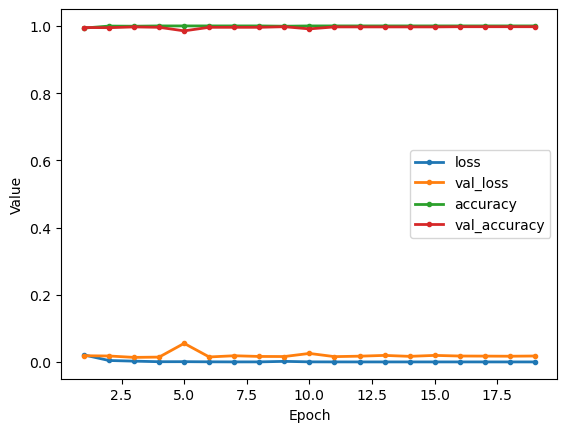

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

40/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

38/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
9260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3377,0.007435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,287,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,328,257 (150.03 MB)

 Trainable params: 39,328,257 (150.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:39 942ms/step - accuracy: 0.5000 - loss: 0.6931

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.4883 - loss: 0.6932 

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.4939 - loss: 0.6932

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.4964 - loss: 0.6932

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.4953 - loss: 0.6931

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.4995 - loss: 0.6931

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.5044 - loss: 0.6931

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5112 - loss: 0.6930

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5167 - loss: 0.6929

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5208 - loss: 0.6929

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5242 - loss: 0.6928

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5286 - loss: 0.6927

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5341 - loss: 0.6926

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5393 - loss: 0.6925

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5442 - loss: 0.6924

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.5495 - loss: 0.6923

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5551 - loss: 0.6922

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5612 - loss: 0.6920

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5674 - loss: 0.6919

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5736 - loss: 0.6917

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5794 - loss: 0.6915

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5850 - loss: 0.6913

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5904 - loss: 0.6911

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5957 - loss: 0.6908

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.6008 - loss: 0.6906

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.6059 - loss: 0.6903

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6109 - loss: 0.6900

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6158 - loss: 0.6897

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6206 - loss: 0.6893

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6253 - loss: 0.6890

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6300 - loss: 0.6886

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6345 - loss: 0.6881

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6389 - loss: 0.6876 

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6432 - loss: 0.6871

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6474 - loss: 0.6866

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6516 - loss: 0.6860

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6556 - loss: 0.6854

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6595 - loss: 0.6847

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6633 - loss: 0.6840

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.6671 - loss: 0.6832

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6708 - loss: 0.6824

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6743 - loss: 0.6815

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6778 - loss: 0.6805

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6811 - loss: 0.6795

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6844 - loss: 0.6785

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6876 - loss: 0.6774

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6908 - loss: 0.6762

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6938 - loss: 0.6750

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6968 - loss: 0.6737

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6997 - loss: 0.6723

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7025 - loss: 0.6709

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7053 - loss: 0.6695

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7080 - loss: 0.6679

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.7106 - loss: 0.6664

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7132 - loss: 0.6648

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7157 - loss: 0.6631

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7181 - loss: 0.6614

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7206 - loss: 0.6596

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7229 - loss: 0.6578

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7252 - loss: 0.6559

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7275 - loss: 0.6540

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7297 - loss: 0.6520

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7319 - loss: 0.6500

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.7340 - loss: 0.6480

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.7361 - loss: 0.6459

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7382 - loss: 0.6438

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7402 - loss: 0.6417

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7422 - loss: 0.6395

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7441 - loss: 0.6374

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7460 - loss: 0.6352

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7479 - loss: 0.6330

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7498 - loss: 0.6307

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7516 - loss: 0.6285

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7533 - loss: 0.6262

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7551 - loss: 0.6240

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7568 - loss: 0.6217

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7585 - loss: 0.6194

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7601 - loss: 0.6172

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7618 - loss: 0.6149

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7634 - loss: 0.6126

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7650 - loss: 0.6103

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7665 - loss: 0.6080

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7681 - loss: 0.6057

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7696 - loss: 0.6035

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.7711 - loss: 0.6012

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7725 - loss: 0.5989

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7740 - loss: 0.5966

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7754 - loss: 0.5944

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7768 - loss: 0.5921

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7782 - loss: 0.5899

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7796 - loss: 0.5876

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7809 - loss: 0.5854

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7822 - loss: 0.5831

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7835 - loss: 0.5809

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7848 - loss: 0.5787

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7861 - loss: 0.5765

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7873 - loss: 0.5743

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7886 - loss: 0.5722

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7898 - loss: 0.5700

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7910 - loss: 0.5678

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7922 - loss: 0.5657

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7933 - loss: 0.5635

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7945 - loss: 0.5614

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7956 - loss: 0.5593

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7968 - loss: 0.5572

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7979 - loss: 0.5551

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7990 - loss: 0.5530

107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.8000 - loss: 0.5510 - val_accuracy: 0.9865 - val_loss: 0.0300


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 34s 323ms/step - accuracy: 1.0000 - loss: 0.0213

  2/107 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.9961 - loss: 0.0258

  3/107 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.9957 - loss: 0.0256

  4/107 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9958 - loss: 0.0244

  5/107 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.9960 - loss: 0.0233

  6/107 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9962 - loss: 0.0223

  7/107 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9964 - loss: 0.0214

  8/107 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9966 - loss: 0.0205

  9/107 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9968 - loss: 0.0199

 10/107 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9970 - loss: 0.0194

 11/107 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9971 - loss: 0.0189

 12/107 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9973 - loss: 0.0185

 13/107 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9974 - loss: 0.0181

 14/107 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9975 - loss: 0.0178

 15/107 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9975 - loss: 0.0175

 16/107 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9975 - loss: 0.0173

 17/107 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9974 - loss: 0.0171

 18/107 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9973 - loss: 0.0170

 19/107 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.9972 - loss: 0.0168

 20/107 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.9972 - loss: 0.0166

 21/107 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.9971 - loss: 0.0164

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9970 - loss: 0.0163

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9970 - loss: 0.0161

 24/107 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9970 - loss: 0.0160

 25/107 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9969 - loss: 0.0158

 26/107 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9969 - loss: 0.0156

 27/107 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9969 - loss: 0.0155

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9969 - loss: 0.0153

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9969 - loss: 0.0152

 30/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9969 - loss: 0.0150

 31/107 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9969 - loss: 0.0149

 32/107 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9969 - loss: 0.0147

 33/107 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9969 - loss: 0.0146

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9969 - loss: 0.0145

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9969 - loss: 0.0144

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9969 - loss: 0.0143

 37/107 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9969 - loss: 0.0141

 38/107 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9969 - loss: 0.0140

 39/107 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9969 - loss: 0.0139

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9969 - loss: 0.0138 

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9969 - loss: 0.0137

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9969 - loss: 0.0136

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9969 - loss: 0.0135

 44/107 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9970 - loss: 0.0134

 45/107 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9969 - loss: 0.0134

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9969 - loss: 0.0133

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9970 - loss: 0.0132

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9969 - loss: 0.0132

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9969 - loss: 0.0132

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9969 - loss: 0.0131

 51/107 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9969 - loss: 0.0131

 52/107 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9969 - loss: 0.0130

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9969 - loss: 0.0130

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9969 - loss: 0.0130

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9969 - loss: 0.0129

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9969 - loss: 0.0129

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9969 - loss: 0.0128

 58/107 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9969 - loss: 0.0128

 59/107 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9969 - loss: 0.0127

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0127

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0127

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0126

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0126

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0125

 65/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0125

 66/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9969 - loss: 0.0125

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9969 - loss: 0.0124

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0124

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0124

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0123

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0123

 72/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0123

 73/107 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0122

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0122

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0122

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0122

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0121

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0121

 79/107 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9969 - loss: 0.0121

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0120

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0120

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0120

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0120

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0119

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0119

 86/107 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9969 - loss: 0.0119

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9969 - loss: 0.0119

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9969 - loss: 0.0118

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9969 - loss: 0.0118

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9970 - loss: 0.0118

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9970 - loss: 0.0118

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9970 - loss: 0.0117

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9970 - loss: 0.0117

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0117

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0117

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0116

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0116

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0116

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9970 - loss: 0.0116

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9970 - loss: 0.0115

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0115

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0115

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0115

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0114

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0114

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0114

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9970 - loss: 0.0114

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9970 - loss: 0.0114 - val_accuracy: 0.9930 - val_loss: 0.0153


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 1.0000 - loss: 0.0017

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 0.0017

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 0.0016

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 0.0017

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 0.0017

  6/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 0.0017

  7/107 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 0.0017

  8/107 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 0.0017

  9/107 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 0.0017

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 0.0017

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 0.0017

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 0.0018

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 0.0018

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 0.0018

 15/107 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 0.0018

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0018

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 0.0018

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0018

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0018

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 0.0017

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 0.0017

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 0.0017

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 0.0017

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 0.0017

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 0.0017

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 0.0016

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016 

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0016

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 0.0016

 44/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 0.0016

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0016

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 51/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0015

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 58/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 65/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 72/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 79/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 86/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9999 - loss: 0.0015

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9999 - loss: 0.0015

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9999 - loss: 0.0015

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9999 - loss: 0.0015

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9999 - loss: 0.0015

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9894 - val_loss: 0.0195


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 1.0000 - loss: 2.9385e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.7803e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 2.9328e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.9692e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 3.0943e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 3.2755e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 3.5453e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 3.6956e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9998 - loss: 6.4388e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9997 - loss: 8.3847e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9996 - loss: 9.7979e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9995 - loss: 0.0011    

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9994 - loss: 0.0012

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9994 - loss: 0.0012

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9994 - loss: 0.0013

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9993 - loss: 0.0013

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9993 - loss: 0.0014

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9993 - loss: 0.0014

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9993 - loss: 0.0014

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9993 - loss: 0.0014

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9993 - loss: 0.0014

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9993 - loss: 0.0014

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9994 - loss: 0.0014

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9994 - loss: 0.0014

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9994 - loss: 0.0014

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9994 - loss: 0.0014 

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9994 - loss: 0.0014

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9994 - loss: 0.0014

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9994 - loss: 0.0013

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9994 - loss: 0.0013

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0013

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0013

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0013

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0013

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9995 - loss: 0.0012

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0012

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0011

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0011

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0011

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9995 - loss: 0.0011

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0011

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9996 - loss: 0.0010

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 0.0010

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9996 - loss: 9.9884e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.9996 - loss: 9.9529e-04 - val_accuracy: 0.9894 - val_loss: 0.0189


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step - accuracy: 1.0000 - loss: 2.0598e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 2.2010e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 2.3105e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 2.2758e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.4590e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 2.5903e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.6317e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.6499e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 2.6388e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 2.6615e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.6637e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 2.6650e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 2.6581e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.6459e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.6343e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.6376e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6354e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6334e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6296e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6247e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6183e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.6122e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.6045e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5955e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5892e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5839e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.5775e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.5712e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5642e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.5564e-04

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5499e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5433e-04

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5365e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5296e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5251e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.5198e-04

 37/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 2.5138e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.5074e-04 

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.5078e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.5082e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.5078e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.5078e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.5071e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.5062e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.5045e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.5026e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.5003e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.4977e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.4951e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.4927e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4901e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4871e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4845e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4823e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4796e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.4771e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.4746e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.4717e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4687e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.4659e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4628e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4597e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4566e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4545e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4521e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4498e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4478e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4457e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4435e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4411e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4390e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4371e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4351e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4330e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4308e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4284e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4261e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.4236e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4210e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4183e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4179e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4173e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4165e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.4157e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.4147e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.4138e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.4128e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.4118e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.4109e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.4103e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.4100e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.4095e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.4089e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4084e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4077e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4070e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4062e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4053e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4043e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4033e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4026e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4019e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4011e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4002e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.3996e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.3989e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.3981e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 2.3974e-04 - val_accuracy: 0.9894 - val_loss: 0.0187


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 24s 235ms/step - accuracy: 1.0000 - loss: 1.3258e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.3304e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.3052e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 1.3033e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 1.2892e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 1.2700e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 1.2653e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 1.2580e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 1.2554e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.2464e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.2451e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 1.2439e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 1.2416e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 1.2369e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2497e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 1.2618e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2720e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2807e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2873e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2924e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.2997e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.3067e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.3122e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.3163e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.3187e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.3212e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.3232e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.3241e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3269e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3300e-04

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3323e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.3354e-04

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3408e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3467e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.3517e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.3561e-04 

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.3597e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.3634e-04

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.3669e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.3802e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 1.3924e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 1.4040e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 1.4154e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 1.4260e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.4354e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.4445e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.4527e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 1.4605e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 1.4675e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 1.4738e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.4796e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.4852e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.4904e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.4952e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.4999e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.5045e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.5087e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.5125e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.5165e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.5201e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.5236e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.5268e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.5299e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.5333e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.5368e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.5399e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.5428e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.5456e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.5482e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.5506e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 1.5527e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5547e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5565e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5583e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5600e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5614e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5627e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 1.5639e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5649e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5657e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5663e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5669e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5674e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5678e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 1.5683e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5687e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5689e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5690e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5690e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5690e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5688e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 1.5687e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5684e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5681e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5677e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5672e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5668e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5662e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.5655e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5648e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5639e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5630e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5621e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5611e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5600e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.5589e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 1.5577e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.5566e-04 - val_accuracy: 0.9894 - val_loss: 0.0201


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 1.0000 - loss: 9.6313e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 9.6326e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 9.1492e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 8.6796e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 8.2853e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 8.0073e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 7.7996e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 7.6894e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 7.5825e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 7.4793e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 7.4550e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.4744e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.5310e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.5750e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.6389e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 7.6802e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.7117e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 7.7454e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 7.7815e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 7.8093e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 7.8545e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 7.8947e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 7.9839e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 8.0682e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 8.1382e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 8.1951e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 8.3151e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 8.4245e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 8.5411e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 8.6456e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 8.7392e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 8.8208e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 8.9385e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 9.0415e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 9.1351e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 9.2168e-05 

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 9.2941e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 9.3609e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 9.4194e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 9.4699e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 9.5286e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 9.5812e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.6369e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.6936e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.7444e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.7893e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.8289e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.8648e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 9.8962e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 9.9243e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 9.9496e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 9.9704e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 9.9891e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.0006e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.0020e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.0035e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.0049e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0061e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0069e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0076e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0083e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0096e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0106e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.0116e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 1.0123e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0130e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0135e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0138e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0140e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0141e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.0140e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 1.0138e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0138e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0136e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0133e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0130e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0126e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.0120e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0115e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0112e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0108e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0104e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0099e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0094e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.0090e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0088e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0086e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0084e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0083e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.0083e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.0081e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0079e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0077e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0074e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0071e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0067e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0063e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0059e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.0058e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0056e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0053e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0051e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0048e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0045e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0041e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0038e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0035e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0031e-04 - val_accuracy: 0.9900 - val_loss: 0.0186


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 33s 312ms/step - accuracy: 1.0000 - loss: 5.4923e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 8.7064e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 9.1545e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 8.9638e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 9.5851e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 9.7755e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 9.8064e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 9.7308e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 9.6261e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 9.4934e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 9.3846e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 9.3043e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 9.2603e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.2080e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 9.1447e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 9.0791e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.1930e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.2753e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.3341e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.3849e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.4381e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.4729e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.4960e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.5092e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.5146e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.5146e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.5092e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.4958e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 9.4760e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.4535e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.4286e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.4017e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 9.3781e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 9.3560e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 9.3355e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 9.3174e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2964e-05 

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2813e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2637e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2436e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2239e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.2043e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 9.1843e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 9.1638e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.1470e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 9.1328e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 9.1165e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 9.0989e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 9.0792e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 9.0582e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.0360e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.0127e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 8.9920e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 8.9717e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 8.9505e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 8.9298e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 8.9095e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 8.8880e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.8658e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.8446e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.8229e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.8004e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.7773e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.7542e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 8.7306e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.7088e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.6869e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.6648e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.6439e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.6235e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.6031e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.5824e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.5617e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.5406e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.5191e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 8.4979e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.4762e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.4548e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.4375e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.4198e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.4019e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.3845e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.3669e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.3500e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.3331e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.3159e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2994e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2827e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2661e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2501e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2341e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2184e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 8.2028e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1870e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1710e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1552e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1401e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1250e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.1105e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 8.0964e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 8.0822e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 8.0682e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 8.0544e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 8.0404e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 8.0263e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 8.0121e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.9979e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 7.9840e-05 - val_accuracy: 0.9900 - val_loss: 0.0199


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step - accuracy: 1.0000 - loss: 6.5583e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 5.4293e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 5.2349e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 6.7946e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 7.3986e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 7.6135e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 7.6293e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 7.5708e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.4867e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.3924e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.3302e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.3890e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.4193e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 7.4534e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 7.4667e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 7.4780e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 7.4883e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 7.5080e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 7.5083e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 7.4977e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 7.4830e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 7.4619e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 7.4329e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.3982e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.3632e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.3493e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.3292e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 7.3074e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 7.2825e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 7.2544e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.2240e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.1918e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.1575e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.1237e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.0892e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 7.0570e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 7.0232e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.9906e-05 

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.9585e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.9406e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.9224e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.9037e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 6.8839e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.8634e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.8426e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.8214e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.7995e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.7763e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 6.7546e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.7328e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 6.7106e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.6879e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.6673e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.6465e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.6256e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.6056e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.5882e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.5712e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5539e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5363e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5187e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5100e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5011e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.4912e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.4866e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4813e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4756e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4708e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4655e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4596e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.4533e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4467e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4404e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4386e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4363e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4345e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4320e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.4289e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4253e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4216e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4175e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4142e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4108e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4067e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 6.4023e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3974e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3923e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3871e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3819e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3768e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3714e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3660e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 6.3603e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3549e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3491e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3430e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3366e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3307e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 6.3250e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 6.3198e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 6.3144e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 6.3090e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 6.3047e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 6.3005e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 6.2968e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 6.2932e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 6.2895e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 6.2859e-05 - val_accuracy: 0.9906 - val_loss: 0.0178


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 3.0025e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 4.8470e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 4.9827e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 4.9321e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.7809e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 4.6458e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 4.5434e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 4.4259e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 4.3139e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.2728e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 4.2395e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 1.0000 - loss: 4.1955e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 1.0000 - loss: 4.1430e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 1.0000 - loss: 4.0877e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 1.0000 - loss: 4.0345e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 1.0000 - loss: 3.9810e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 3.9357e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 4.0757e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 4.1919e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 4.2835e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 4.3569e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 1.0000 - loss: 4.4167e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 1.0000 - loss: 4.4632e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 4.5113e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 4.5494e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 4.5839e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 1.0000 - loss: 4.6114e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.6319e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.6483e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.6615e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.6711e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.6801e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.6868e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6923e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6954e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6969e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6966e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6961e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6966e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6976e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.6969e-05 

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.6949e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.6923e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.6904e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.6887e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.6857e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.6866e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.6865e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.6853e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.6829e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.6797e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.6783e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.6775e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.6759e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.6738e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.6708e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.6710e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.6707e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.6696e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.6680e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.6657e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.6633e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.6606e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.6573e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.6540e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.6502e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6462e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6421e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6380e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6337e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6290e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6241e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6188e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.6132e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.6077e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.6022e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.5994e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.5965e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 4.5932e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5895e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5855e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5815e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5770e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5722e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5671e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.5618e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5563e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5508e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5452e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5401e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5347e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5291e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.5239e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5187e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5134e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5079e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5025e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.4970e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.4918e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.4864e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4809e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4755e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4700e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4649e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4596e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.4542e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 4.4489e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 1.0000 - loss: 4.4437e-05 - val_accuracy: 0.9900 - val_loss: 0.0194


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 1.0000 - loss: 1.7459e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 1.0000 - loss: 1.8509e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 1.0000 - loss: 1.8221e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.8580e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 1.9126e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.9599e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.0575e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.1193e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.1570e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.1732e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.1985e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.2675e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.3156e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.3539e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.3929e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.4218e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.4522e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.4771e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.4970e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.5137e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.6617e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.7931e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.9098e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.0109e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.0996e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 3.1786e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.2487e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.3090e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.3644e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 3.4121e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.4562e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.4938e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.5257e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.5528e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 3.5832e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 3.6093e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 3.6321e-05 

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 3.6524e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 3.6693e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 3.6849e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 3.6995e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 3.7125e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 3.7267e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 3.7408e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7545e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7660e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7756e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7839e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7904e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7956e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 3.7998e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8028e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8091e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8149e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8204e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8250e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.8292e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8324e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8346e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8361e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8369e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8378e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.8384e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 3.8384e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8379e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8372e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8360e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8345e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8334e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8320e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 3.8300e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8288e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8277e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8262e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8249e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8234e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8218e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 3.8201e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8179e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8155e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8128e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8106e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8096e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8082e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 3.8066e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.8048e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.8027e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.8006e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.7983e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.7958e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.7930e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.7901e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7872e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7842e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7810e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7777e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7745e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7711e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.7677e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.7643e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.7608e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.7571e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.7564e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 3.7556e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.7546e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.7535e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.7523e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 3.7511e-05 - val_accuracy: 0.9912 - val_loss: 0.0184


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - accuracy: 1.0000 - loss: 2.3726e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.0438e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 1.9661e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 2.0686e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 2.2309e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 2.3190e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 2.4100e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 3.2208e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 3.7648e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 4.1395e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 1.0000 - loss: 4.3990e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 4.5790e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 4.7012e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 4.7951e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.8651e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.9135e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.9437e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.9582e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 4.9620e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.9610e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.9598e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.9531e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.9402e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.9233e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.9027e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.8822e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.8619e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.8395e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.8164e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.7940e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.7695e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.7445e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.7199e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.7031e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6855e-05 

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6676e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6490e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6349e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6191e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6031e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.5865e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5716e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5613e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5514e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5404e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5283e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 4.5173e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5057e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 4.4938e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4823e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4704e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4581e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4452e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4318e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4180e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 4.4040e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.3897e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.3757e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.3617e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.3480e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.3346e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.3214e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.3079e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 4.2957e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2835e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2713e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2591e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2469e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2347e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2225e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 4.2104e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1981e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1858e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1734e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1610e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1485e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1361e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.1240e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.1120e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.1003e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.0886e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.0777e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.0670e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.0563e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.0461e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.0361e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.0261e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.0160e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 4.0061e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.9961e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.9861e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 3.9765e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9670e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9574e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9478e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9385e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9292e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9200e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 3.9111e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.9023e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.8934e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.8845e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.8755e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.8667e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.8579e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.8492e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.8405e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 3.8319e-05 - val_accuracy: 0.9900 - val_loss: 0.0207



[Train Accuracy: 100.00% - Test Accuracy: 99.34%]


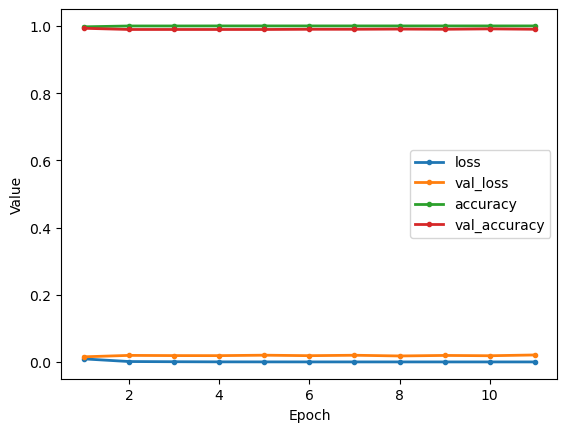

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step

 5/67 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

 9/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

22/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

44/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

48/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

52/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step

 5/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 9/67 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/67 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/67 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

34/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

43/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

48/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

52/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/GATA/report_SP7UZO06.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################